In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import subprocess
import re
import collections
import time
import numpy as np

import seaborn as sns

np.random.seed(42)

def time_gemm_numpy(N):
    A = np.random.randn(N, N).astype(np.float32)
    B = np.random.randn(N, N).astype(np.float32)
    _ = A @ B  # Warm-up

    dts = []
    for _ in range(3):
        t0 = time.monotonic()
        _ = A @ B
        dt = (time.monotonic() - t0) * 1e3
        dts.append(dt)
    avg_dt = sum(dts) / len(dts)
    gflops = 2 * N**3 / (avg_dt * 1e6)
    return float(gflops)

In [7]:
# Compile
subprocess.run(f"clang -O2 -march=native ./gemm_kernels.c -o ./gemm", shell=True, check=True)

# Define the range of sizes
kernel_num = [0, 1]
sizes = np.arange(128, 4097, 128)
gflops_values = collections.defaultdict(list)
ref_values = []

# Execute the gemm program for each size and extract the GFLOP/s value
for size in sizes:
    # NumPy ref
    ref_values.append(time_gemm_numpy(size))

    for k in kernel_num:
        try:
            # Execute the gemm program
            result = subprocess.run(f"./gemm {k} {size}", shell=True, capture_output=True, text=True, check=True)
            output = result.stdout.strip()
            time.sleep(0.1)
            
            # Extract the GFLOP/s value using regex
            match = re.search(r"GFLOP/s:\s+(\d+\.\d+)", output)
            if match:
                gflops = float(match.group(1))
                gflops_values[k].append(gflops)
                print(f"Kernel {k}, Size {size}: {gflops} GFLOP/s")
            else:
                print(f"Could not parse output for kernel {k}, size {size}: {output}")
                gflops_values[k].append(None)
        except subprocess.CalledProcessError as e:
            print(f"Error executing gemm for size {size}: {e}")
            gflops_values[k].append(None)

print(gflops_values, ref_values)

Kernel 0, Size 128: 32.97 GFLOP/s
Kernel 1, Size 128: 35.92 GFLOP/s
Kernel 0, Size 256: 40.45 GFLOP/s
Kernel 1, Size 256: 38.12 GFLOP/s
Kernel 0, Size 384: 42.42 GFLOP/s
Kernel 1, Size 384: 36.7 GFLOP/s
Kernel 0, Size 512: 42.96 GFLOP/s
Kernel 1, Size 512: 40.52 GFLOP/s
Kernel 0, Size 640: 38.98 GFLOP/s
Kernel 1, Size 640: 39.41 GFLOP/s
Kernel 0, Size 768: 24.43 GFLOP/s
Kernel 1, Size 768: 41.28 GFLOP/s
Kernel 0, Size 896: 18.74 GFLOP/s
Kernel 1, Size 896: 41.39 GFLOP/s
Kernel 0, Size 1024: 16.77 GFLOP/s
Kernel 1, Size 1024: 41.8 GFLOP/s
Kernel 0, Size 1152: 16.66 GFLOP/s
Kernel 1, Size 1152: 41.61 GFLOP/s
Kernel 0, Size 1280: 16.53 GFLOP/s
Kernel 1, Size 1280: 41.57 GFLOP/s
Kernel 0, Size 1408: 17.95 GFLOP/s
Kernel 1, Size 1408: 40.79 GFLOP/s
Kernel 0, Size 1536: 18.31 GFLOP/s
Kernel 1, Size 1536: 41.98 GFLOP/s
Kernel 0, Size 1664: 17.81 GFLOP/s
Kernel 1, Size 1664: 40.88 GFLOP/s
Kernel 0, Size 1792: 17.73 GFLOP/s
Kernel 1, Size 1792: 40.97 GFLOP/s
Kernel 0, Size 1920: 17.82 GFLOP/s
K

<Figure size 640x480 with 0 Axes>

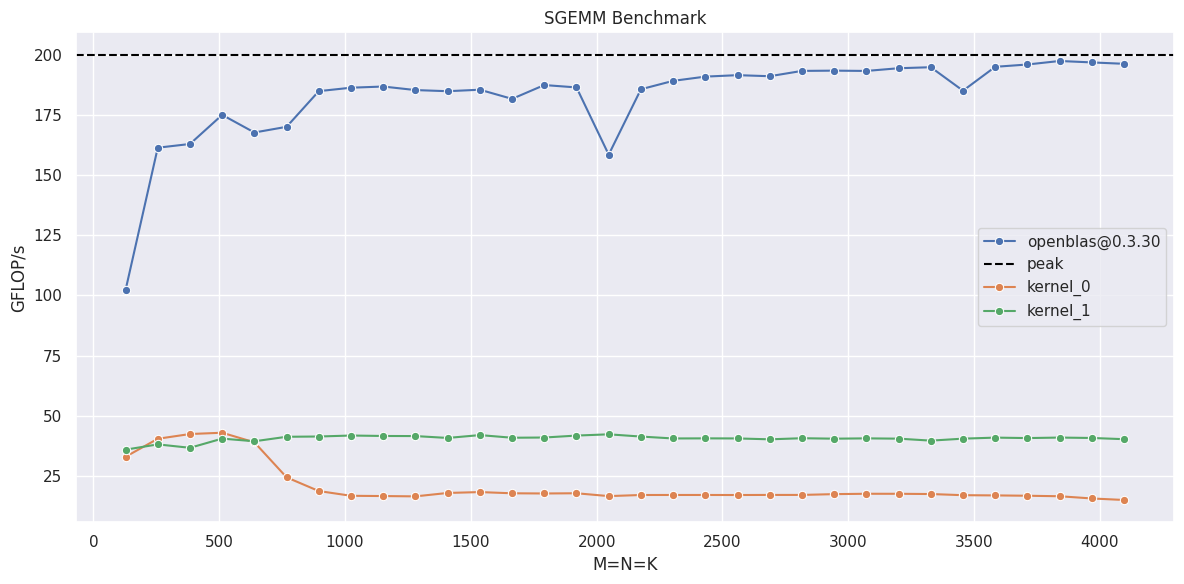

In [8]:
import matplotlib.pyplot as plt

sns.set_theme()
sns.despine()

plt.figure(figsize=(12, 6))
sns.lineplot(x=sizes, y=ref_values, label='openblas@0.3.30', marker='o')
plt.axhline(y=200, color='black', linestyle='--', label='peak')

for k in kernel_num:
  sns.lineplot(x=sizes, y=gflops_values[k], label=f'kernel_{k}', marker='o')
plt.title('SGEMM Benchmark')
plt.xlabel('M=N=K')
plt.ylabel('GFLOP/s')
plt.legend()
plt.tight_layout()
plt.show()